In [1]:
import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import os

In [2]:
# Disable CUDA, not necessary for this example
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
# CUDA is not necessary for the examples in this notebook.
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [21]:
if physical_devices:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(physical_devices), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPU


In [5]:
if physical_devices:
  # Restrict TensorFlow to only use the first GPU
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(physical_devices), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPU


## Create a Custom TensorFlow Model

* Inherit from `tf.keras.Model`.
* Don't forget `super(ModelName, self).__init__()`.
* Define all layers in `__init__()`.
* Construct forward pass in `call(self, x)`. 

In [6]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.neuron = tf.keras.layers.Dense(1)

    def call(self, x):
        return self.neuron(x)

`MyModel` is not very interesting, it is just `y = mx + b`. If you want to build a real neural network you would require more [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) and some [non-linearities](https://www.tensorflow.org/api_docs/python/tf/keras/activations) (e.g. ReLU). 

Usually each layer is put through a non-linearity:

```
def call(self, x):
    return tf.nn.relu(self.neuron(x))
```

You can reuse `x` during the forward pass:
```
def call(self, x):
    x = tf.nn.relu(self.neuron(x))
    x = tf.nn.relu(self.another_neuron(x))
    return x
```

## Does MyModel work?

The first step after defining is to test `forward`. We define a single instance `x`, which can be anything as long as the dimensions are correct. In case of `MyModel` we want to have input dimensions `N x 1` and obtain outputs of same dimensionality.

In [7]:
x = np.array([[1,2,3,4]])
print(type(x))

# convert from numpy to torch
x = tf.convert_to_tensor(x)
print(type(x))

<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [8]:
model = MyModel()

In [9]:
model.build(input_shape=(1,1))
# model.build((1,1))

In [10]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.call(x)

InvalidArgumentError: Matrix size-incompatible: In[0]: [1,4], In[1]: [1,1] [Op:MatMul]

__Note:__ This did not work out. Something with the tensor-shapes is wrong. 

In [12]:
x.shape

TensorShape([1, 4])

Our input x has dimensionality `1 x N` instead of `N x 1`. 

In [13]:
# Now we define our x the correct way:
x = np.array([[1], [2], [3], [4]], dtype=np.float32)
x = tf.convert_to_tensor(x)
x.shape

TensorShape([4, 1])

In [14]:
y = model(x)

In [15]:
print(y)
print(y.shape)

tf.Tensor(
[[1.5285057]
 [3.0570114]
 [4.585517 ]
 [6.1140227]], shape=(4, 1), dtype=float32)
(4, 1)


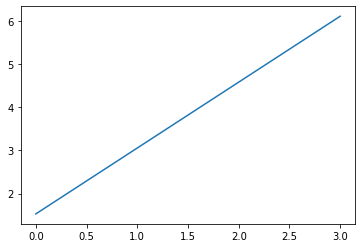

In [16]:
# y_graph = np.asarray(y[0])
plt.plot(y)

## Train MyModel

Next we want to generate some GT line-data and simulate noisy measurements from it. With these measurments we train our model and fit a line.

In [17]:
m = 1.2
b = -4.

In [18]:
# Train-Data
x = np.linspace(-1,1,100, dtype=np.float32)
gt = m*x + b
y = np.random.normal(gt, 1.).astype(np.float32)

In [19]:
# Note that the shapes are not correct yet.
print(x.shape, y.shape)

(100,) (100,)


In [20]:
x = x[:, np.newaxis]
y = y[:, np.newaxis]
print(x.shape, y.shape)

(100, 1) (100, 1)


In [21]:
x_tf = tf.convert_to_tensor(x)
y_tf = tf.convert_to_tensor(y)

In [22]:
# Test-Data
test_x = tf.convert_to_tensor(np.array([[-2], [2]], dtype=np.float32))

In [23]:
pred_untrained = model(test_x)

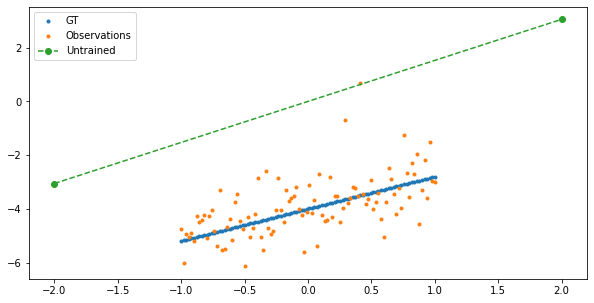

In [24]:
plt.figure(figsize=(10,5))
plt.plot(x, gt, '.', label='GT')
plt.plot(x, y, '.', label='Observations')
plt.plot(test_x, pred_untrained, 'o--', label='Untrained')
plt.legend();

### Loss-Function

In [25]:
loss_function = tf.keras.losses.MSE

### Optimizer

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

### Train-Function

This is a very simple train function i.e. without dataloaders and batching. We just iterate over all samples one-by-one (batch-size = 1).

In [27]:
# Since we loop over x, the dimension gets reduced by one:
for x_ in x_tf:
    print(x_.shape)
    break

(1,)


In [28]:
# Hence we have to use unsqueeze to add a singleton dimension:
for x_ in x_tf:
    x_ = tf.expand_dims(x_, 0)
    print(x_.shape)
    break

(1, 1)


In [29]:
def train(model, x, y, loss_function, optimizer, num_epochs):
    
    running_loss = 0.0
    for e in tqdm(range(num_epochs)):
        for x_, y_ in zip(x, y):
            x_ = tf.expand_dims(x_, 0) 
            y_ = tf.expand_dims(y_, 0)
            
            with tf.GradientTape() as tape:
                y_hat = model(x_, training=True)
                loss = loss_function(y_, y_hat)
            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            
            running_loss += float(loss) # cast to float
            
        running_loss /= len(x)
        if e % 100 == 0:
            running_loss /= 100.
            print('Epoch: {:4}; Train-Loss: {}'.format(e, np.round(running_loss, 3)))
            running_loss = 0.0

In [30]:
train(model, x_tf, y_tf, loss_function, optimizer, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:    0; Train-Loss: 0.159
Epoch:  100; Train-Loss: 0.096
Epoch:  200; Train-Loss: 0.05
Epoch:  300; Train-Loss: 0.023
Epoch:  400; Train-Loss: 0.011
Epoch:  500; Train-Loss: 0.009
Epoch:  600; Train-Loss: 0.008
Epoch:  700; Train-Loss: 0.008
Epoch:  800; Train-Loss: 0.008
Epoch:  900; Train-Loss: 0.008


In [31]:
pred = model.predict(test_x)

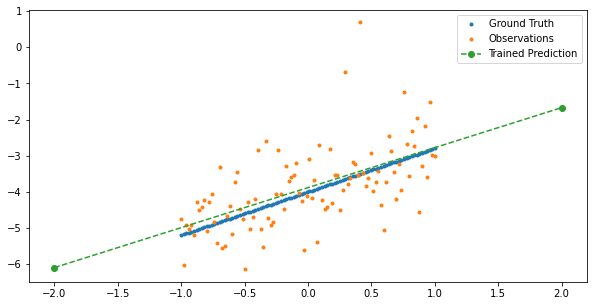

In [32]:
plt.figure(figsize=(10,5))
plt.plot(x, gt, '.', label='Ground Truth')
plt.plot(x, y, '.', label='Observations')
plt.plot(test_x, pred, 'o--', label='Trained Prediction')
plt.legend();

In [33]:
print(model.neuron.weights[0].numpy())
a = model.neuron.weights[0].numpy()[0][0]
# float(a)
a

c = model.neuron.bias.numpy()[0]
c

[[1.105899]]


-3.8840792

In [34]:
print('GT line:        y = {:2.2f}*x + {:2.2f}'.format(m, b))
print('Predicted line: y = {:2.2f}*x + {:2.2f}'.format(float(model.neuron.weights[0].numpy()[0][0]), float(c)))

GT line:        y = 1.20*x + -4.00
Predicted line: y = 1.11*x + -3.88


### Speeding-up Training

Default mode of TF2 is eager execution. This is great for debugging, but very slow. We can speed-up training by compiling the static computation-graph. Just use the `@tf.function` decorator.

More information can be found [here](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch#speeding-up_your_training_step_with_tffunction).

In [35]:
def train_fast(model, x, y, loss_function, optimizer, num_epochs):
    @tf.function
    def train_step(x_, y_):
        with tf.GradientTape() as tape:
            y_hat = model(x_, training=True)
            loss = loss_function(y_, y_hat)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        return loss
    
    running_loss = 0.0
    for e in tqdm(range(num_epochs)):
        for x_, y_ in zip(x, y):
            x_ = tf.expand_dims(x_, 0) 
            y_ = tf.expand_dims(y_, 0)
            
            loss = train_step(x_, y_)
            
            running_loss += float(loss) # cast to float
            
        running_loss /= len(x)
        if e % 100 == 0:
            running_loss /= 100.
            print('Epoch: {:4}; Train-Loss: {}'.format(e, np.round(running_loss, 3)))
            running_loss = 0.0

In [36]:
# A new model for new training.
model = MyModel()

In [37]:
model.build((1,1))

In [38]:
train_fast(model, x_tf, y_tf, loss_function, optimizer, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:    0; Train-Loss: 0.158
Epoch:  100; Train-Loss: 0.089
Epoch:  200; Train-Loss: 0.046
Epoch:  300; Train-Loss: 0.021
Epoch:  400; Train-Loss: 0.011
Epoch:  500; Train-Loss: 0.008
Epoch:  600; Train-Loss: 0.008
Epoch:  700; Train-Loss: 0.008
Epoch:  800; Train-Loss: 0.008
Epoch:  900; Train-Loss: 0.008


In [39]:
pred = model.predict(test_x)

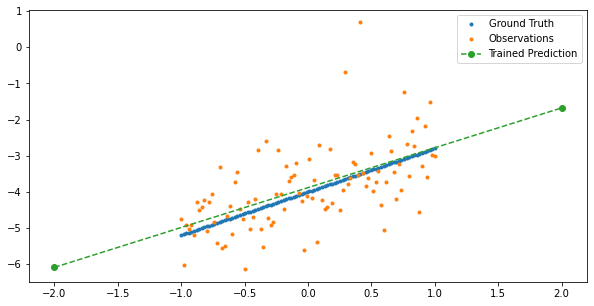

In [40]:
plt.figure(figsize=(10,5))
plt.plot(x, gt, '.', label='Ground Truth')
plt.plot(x, y, '.', label='Observations')
plt.plot(test_x, pred, 'o--', label='Trained Prediction')
plt.legend();

In [41]:
print('GT line:        y = {:2.2f}*x + {:2.2f}'.format(m, b))
print('Predicted line: y = {:2.2f}*x + {:2.2f}'.format(float(model.neuron.weights[0]), float(model.neuron.bias)))

GT line:        y = 1.20*x + -4.00


TypeError: float() argument must be a string or a number, not 'ResourceVariable'